In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-approval-classification-data/loan_data.csv


In [43]:
loan_data = pd.read_csv('/kaggle/input/loan-approval-classification-data/loan_data.csv')
loan_data.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


<Axes: >

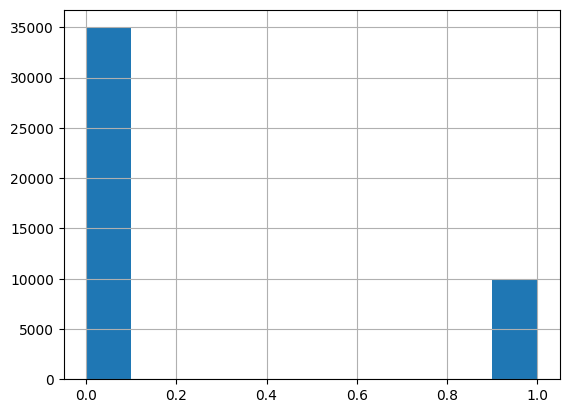

In [44]:
loan_data.loan_status.hist()

In [45]:
loan_data.dtypes

person_age                        float64
person_gender                      object
person_education                   object
person_income                     float64
person_emp_exp                      int64
person_home_ownership              object
loan_amnt                         float64
loan_intent                        object
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                        int64
previous_loan_defaults_on_file     object
loan_status                         int64
dtype: object

In [46]:
loan_data.isna().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [47]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

X = loan_data.drop('loan_status', axis=1)
y = loan_data.loan_status

label_encoder = LabelEncoder()
categorical_cols = X.axes[1][X.dtypes == object]
X[categorical_cols] = X[categorical_cols].apply(label_encoder.fit_transform)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)

In [48]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=123)

params_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9]
}

grid_search_random_forest = GridSearchCV(estimator=rf_model,
                                         param_grid=params_grid,
                                         scoring="f1_macro",
                                         cv=5)

grid_search_random_forest.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             param_grid={'max_depth': [3, 6, 9], 'max_leaf_nodes': [3, 6, 9],
                         'n_estimators': [25, 50, 100]},
             scoring='f1_macro')

In [49]:
from sklearn.metrics import f1_score

rf_model = grid_search_random_forest.best_estimator_
rf_preds = rf_model.predict(X_test)
print(f1_score(y_test, rf_preds, average = 'macro'))

0.857620369739304


In [50]:
!pip install catboost

In [51]:
from catboost import Pool

X = loan_data.drop('loan_status', axis=1)
y = loan_data.loan_status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=123, stratify=y_train)

train_pool = Pool(X_train, y_train, cat_features=categorical_cols.values)

val_pool = Pool(X_val, y_val, cat_features=categorical_cols.values)

test_pool = Pool(X_val, y_val, cat_features=categorical_cols.values)

In [52]:
from optuna import create_study
from optuna.samplers import TPESampler
from catboost.utils import eval_metric
from catboost import CatBoostClassifier


def objective(trial):
  params = {
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
      'depth': trial.suggest_int('depth', 3, 10),
      'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
      'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain'])
      }

  model = CatBoostClassifier(**params, random_seed=42, task_type='GPU', verbose=0, iterations = 400)
  model.fit(train_pool, eval_set=val_pool)
  y_pred = model.predict_proba(val_pool)
  return eval_metric(val_pool.get_label(), y_pred[:, 1], 'AUC')

sampler = TPESampler(seed=123)
study = create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=10)

[I 2024-11-17 19:11:26,341] A new study created in memory with name: no-name-80f911b6-8f87-4bd0-9180-12b27549578a
[I 2024-11-17 19:11:33,381] Trial 0 finished with value: 0.9762063616071428 and parameters: {'learning_rate': 0.07268222670380756, 'depth': 5, 'l2_leaf_reg': 3.041663082077828, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.9762063616071428.
[I 2024-11-17 19:13:34,796] Trial 1 finished with value: 0.977109375 and parameters: {'learning_rate': 0.04807958141120149, 'depth': 10, 'l2_leaf_reg': 7.1634676472637695, 'boosting_type': 'Ordered'}. Best is trial 1 with value: 0.977109375.
[I 2024-11-17 19:13:48,179] Trial 2 finished with value: 0.9764199776785715 and parameters: {'learning_rate': 0.04088602145357825, 'depth': 8, 'l2_leaf_reg': 4.947150202116619, 'boosting_type': 'Plain'}. Best is trial 1 with value: 0.977109375.
[I 2024-11-17 19:13:54,359] Trial 3 finished with value: 0.9756133928571429 and parameters: {'learning_rate': 0.07641958651588322, 'depth': 4, 'l2_

In [53]:
model = CatBoostClassifier(**study.best_params, random_seed=42, task_type='GPU')

model.fit(train_pool, verbose=0, eval_set=val_pool)
y_pred = model.predict(test_pool)
print(f1_score(test_pool.get_label(), y_pred, average = 'macro'))

0.9024163637848006
